In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path


from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.algorithms.ubc_exploitability import game_tree_size

from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, projectUMAP, fitGMM, projectTSNE
from open_spiel.python.examples.ubc_sample_game_tree import NodeType

from auctions.webutils import *



import bokeh
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap
from bokeh.palettes import Category10_10, Magma256, Spectral10, Category20_20
import copy
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

output_notebook()
from open_spiel.python.algorithms import cfr, outcome_sampling_mccfr, expected_game_score, exploitability, get_all_states_with_policy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [29]:
N_SAMPLES = 100_000

In [30]:
### Load game
game = smart_load_clock_auction('small_game_2.json')

Reading from env variable CLOCK_AUCTION_CONFIG_DIR. If it is not set, there will be trouble.
CLOCK_AUCTION_CONFIG_DIR=/apps/open_spiel/configs
Parsing configuration from /apps/open_spiel/configs/small_game_2.json
Done config parsing


In [4]:
game_tree_size(game.new_initial_state())

5677

In [37]:
def knuth_estimate(game, n_samples):
    estimates = []
    for i in tqdm(range(N_SAMPLES)):
        estimate = 1
        state = game.new_initial_state()
        while not state.is_terminal():
            if state.is_chance_node():
                outcomes = state.chance_outcomes()
                num_actions = len(outcomes)
                action_list, prob_list = zip(*outcomes)
                action = fast_choice(action_list, prob_list)
            else:
                legal_actions = state.legal_actions(state.current_player())
                num_actions = len(legal_actions)
                action = np.random.choice(legal_actions)

            estimate *= num_actions
            state.apply_action(action)
        estimates.append(estimate)
    estimates = pd.Series(estimates)
    # # testing for CIs
    # return estimates

    # original code
    return estimates.mean(), estimates.std()

In [10]:
samples = knuth_estimate(game, N_SAMPLES)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:15<00:00, 6389.95it/s]


Text(0.5, 0, 'Tree size sample')

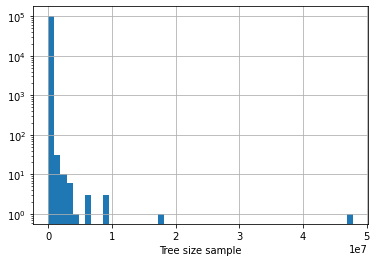

In [19]:
plt = samples.hist(bins=50)
plt.semilogy()
plt.set_xlabel('Tree size sample')

In [20]:
pd.Series(samples).mean()

3967.95712

In [ ]:
pd.Series(estimates).describe()

In [4]:
template_config =  {
    "activity": [
        10
    ],
    "increment": 0.1,
    "information_policy": "show_demand",
    "licenses": [
        1,
    ],
    "opening_price": [
        10
    ],
    "undersell_rule": "undersell",
    "players": [
        {
            "type": [
                {
                    "value": [
                        20
                    ],
                    "budget": 20,
                    "prob": 1.0
                },
            ]
        },
        {
            "type": [
                {
                    "value": [
                        20
                    ],
                    "budget": 20,
                    "prob": 1.0
                },
            ]
        }
    ]
}

In [38]:
def write_config(config):
    players = len(config['players'])
    products = len(config['licenses'])
    licenses = config['licenses'][0]
    information_policy = config['information_policy']
    undersell_rule = config['undersell_rule']
    n_products = len(config['licenses'])
    name = f'graphgames/{n_products}_{players}_{products}_{licenses}_{information_policy}_{undersell_rule}.json'
    with open(name, 'w') as f:
        json.dump(config, f)
    return name

In [ ]:
knuth = False
N_SAMPLES = 100_000

records = []

for undersell in ['undersell', 'undersell_allowed']:
    config = copy.deepcopy(template_config)
    config['undersell_rule'] = undersell
    for information_policy in ['show_demand', 'hide_demand']:
        config['information_policy'] = information_policy
        for i in range(1, 7):
            config['licenses'] = [i] * len(config['licenses'])
            for p in config['players']:
                p['type'][0]['budget'] = 20 * i
            name = write_config(config)
            print(name)
            game = smart_load_clock_auction(f'/apps/open_spiel/notebooks/{name}')
            size = game_tree_size(game.new_initial_state())
            info_state_size = len(get_all_states_with_policy.get_all_info_states_with_policy(game))
            action_info_state_size = len(get_all_states_with_policy.get_all_info_states_with_policy(game, include_terminals=False))
            record = dict()
            record['game'] = name
            record['size'] = size
            record['info_state_size_with_terminals'] = info_state_size
            record['action_info_state_size'] = action_info_state_size
            record['undersell_rule'] = undersell
            record['information_policy'] = information_policy
            record['n_licenses'] = i
            
            
            if knuth:
                knuth_size, knuth_std = knuth_estimate(game, N_SAMPLES)
                record['knuth_size'] = knuth_size
                record['knuth_std'] = knuth_std

            records.append(record)

In [ ]:
df = pd.DataFrame.from_records(records)

In [ ]:
df = pd.DataFrame.from_records(records)
df['size'] = df['size'].astype(float)
pd.options.display.float_format = '{:,}'.format
df.round(2)

In [39]:
template_config_2 =  {
    "activity": [
        10, 10
    ],
    "increment": 0.1,
    "information_policy": "show_demand",
    "licenses": [
        1, 1
    ],
    "opening_price": [
        10, 10
    ],
    "undersell_rule": "undersell",
    "players": [
        {
            "type": [
                {
                    "value": [
                        20, 20
                    ],
                    "budget": 20,
                    "prob": 1.0
                },
            ]
        },
        {
            "type": [
                {
                    "value": [
                        20, 20
                    ],
                    "budget": 20,
                    "prob": 1.0
                },
            ]
        }
    ]
}

In [ ]:
knuth = False
N_SAMPLES = 100_000

records = []

n_products = 2

for undersell in ['undersell', 'undersell_allowed']:
    config = copy.deepcopy(template_config_2)
    config['undersell_rule'] = undersell
    for information_policy in ['show_demand', 'hide_demand']:
        config['information_policy'] = information_policy
        for i in range(1, 6):
            config['licenses'] = [i] * len(config['licenses'])
            for p in config['players']:
                p['type'][0]['budget'] = 20 * i
            name = write_config(config)
            print(name)
            game = smart_load_clock_auction(f'/apps/open_spiel/notebooks/{name}')
            size = game_tree_size(game.new_initial_state())
            print(size)
            record = dict()
            record['game'] = name
            record['undersell_rule'] = undersell
            record['information_policy'] = information_policy
            record['n_licenses'] = i
            record['n_products'] = n_products
            knuth_size, knuth_std = knuth_estimate(game, N_SAMPLES)
            record['knuth_size'] = knuth_size
            record['knuth_std'] = knuth_std
            records.append(record)

graphgames/2_2_2_1_show_demand_undersell.json
283


Parsing configuration from /apps/open_spiel/notebooks/graphgames/2_2_2_1_show_demand_undersell.json
Done config parsing
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:13<00:00, 7389.49it/s]
Parsing configuration from /apps/open_spiel/notebooks/graphgames/2_2_2_2_show_demand_undersell.json
Done config parsing


graphgames/2_2_2_2_show_demand_undersell.json


In [ ]:
df = pd.DataFrame.from_records(records)
df.to_csv("2_size.csv", index=False)
df['size'] = df['size'].astype(float)
pd.options.display.float_format = '{:,}'.format
df.round(2)

In [ ]:
print("HI")